<a href="https://colab.research.google.com/github/TimOgden/RoastBot/blob/master/RoastTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np
import time
import collections
import pandas
from tqdm.notebook import tqdm
import json
import random
import matplotlib.pyplot as plt
import re
import os
#from PIL import Image

In [4]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(1000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

In [5]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [6]:
BATCH_SIZE = 12

In [7]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model=256, dff=2048, dropout=.1, name=None):
        super().__init__(name=name)
        self.self_attention = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)
        self.fc1 = tf.keras.layers.Dense(dff, activation=tf.keras.activations.gelu)
        self.fc2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.layer_norm2 = tf.keras.layers.LayerNormalization()

    def call(self, x, training, mask):
        attention_weights, _ = self.self_attention(x, x, attention_mask=mask,
                                                    return_attention_scores=True)
        normalized = self.layer_norm1(x + attention_weights)
        x = self.fc2(self.dropout(self.fc1(normalized), training=training))
        return self.layer_norm2(x + normalized)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)

        self.fc1 = tf.keras.layers.Dense(dff, activation=tf.keras.activations.gelu)
        self.fc2 = tf.keras.layers.Dense(d_model)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        seq_len = x.shape[1]
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask,
                                              return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        enc_output = enc_output[:, :seq_len, :]
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask,
                                    return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.fc2(self.dropout3(self.fc1(out2), training=training))
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [8]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, batch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.batch_size = batch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [self.batch_size, -1, patch_dims])
        return patches

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim, batch_size):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.batch_size = batch_size

    def call(self, patch):
        #print('Patches shape:',patch.shape)
        
        positions = tf.expand_dims(tf.range(start=0, limit=self.num_patches, delta=1), 0)
        if self.batch_size>1:
            positions = tf.tile(positions,[self.batch_size,1])
        #print('Positions shape:',positions.shape)
        projection = self.projection(patch)
        embeddings = self.position_embedding(positions)
        #print('Projection shape:', projection.shape)
        #print('Embeddings shape:', embeddings.shape)
        encoded = projection + embeddings
        return encoded

In [9]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_size,
               maximum_positional_encoding, batch_size, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.input_size = input_size
        self.num_layers = num_layers
        self.patches = Patches(16, batch_size)
        self.patch_encoder = PatchEncoder(576, d_model, batch_size)
        self.pos_encoding = positional_encoding(maximum_positional_encoding,
                                                self.d_model)
        self.enc_layers = [EncoderLayer(num_heads, d_model, dff, dropout=rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(74)
    def call(self, x, training, mask):
        patches = self.patches(x)
        x = self.patch_encoder(patches)
        seq_len = tf.shape(x)[1]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        x = self.dense(self.flatten(x))
        return tf.reshape(x, [-1, 74, 1])

In [10]:
sample_encoder = Encoder(num_layers=1, d_model=256, num_heads=8,
                         dff=1024, input_size=16*16*3, batch_size=12,
                         maximum_positional_encoding=10000)
temp_input = tf.random.uniform((BATCH_SIZE,384,384,3), dtype=tf.float32, minval=0, maxval=1.)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
print(sample_encoder_output.shape)

(12, 74, 1)


In [11]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        #print('Seq length:', seq_len)
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #print('Sequence shape:', x.shape)
        #print('Encoder output shape:', enc_output.shape)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        #print('Before decoder layers shape:', x.shape)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [12]:
sample_decoder = Decoder(num_layers=1, d_model=256, num_heads=8,
                         dff=1024, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((BATCH_SIZE, 1), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer1_block2'].shape

(TensorShape([12, 1, 256]), TensorShape([12, 8, 1, 1]))

In [13]:
def augmentation_model():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-.125,.125)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=(.5,1.5))
    ])
    return model

In [14]:
class Transformer(tf.keras.Model):
    def __init__(self, num_encoders, num_decoders, d_model, num_heads, dff,
               input_size, target_vocab_size, img_input, target, batch_size, rate=0.1):
        super(Transformer, self).__init__()
        self.augmenter = augmentation_model()
        self.tokenizer = Encoder(num_encoders, d_model, num_heads, dff,
                                input_size, img_input, batch_size, rate)
        self.decoder = Decoder(num_decoders, d_model, num_heads, dff,
                               target_vocab_size, target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
    def call(self, x):
        inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask = x
        enc_output = self.tokenizer(self.augmenter(inp), training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask
        )

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [15]:
sample_transformer = Transformer(
    num_encoders=1, num_decoders=1, d_model = 256, num_heads = 8, dff = 2048,
    input_size = 9*16*16*3, target_vocab_size = 8000, batch_size = 12,
    img_input=10000, target=6000)

temp_input = tf.random.uniform((BATCH_SIZE,16,16,3), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((BATCH_SIZE, 74), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer((temp_input, temp_target, False,
                               None,
                               None,
                               None))

fn_out.shape

TensorShape([12, 74, 8000])

In [16]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq,0),tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [17]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)
    return mask # (seq_len, seq_len)

In [18]:
def create_masks(tar):
    # Encoder padding mask
    #enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(tar)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask, dec_padding_mask

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), dtype=real.dtype))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

In [111]:
transformer = Transformer(num_encoders=2, num_decoders=2, d_model=768, num_heads = 8, dff = 2048,
    input_size = 9*16*16*3, target_vocab_size = 8000, batch_size=BATCH_SIZE,
    img_input=10000, target=6000)
#if os.path.exists('./checkpoints/transformer_base_model.index'):
#    transformer.load_weights('./checkpoints/transformer_base_model')

In [112]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, beta_1=.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [44]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [23]:
DEFAULT_TOP_K = 8000

In [24]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(tf.image.resize(img, (384, 384)), tf.float32) / 255.
    return img, image_path

In [52]:
def get_data(path, annotations_json, is_roast=False, split=[.8,.1,.1], subset=None, tokenizer=None, 
             batch_size=16, return_text=False):
    with open(annotations_json, 'r') as f:
        annotations = json.load(f)
    
    image_path_to_caption = collections.defaultdict(list)
    if is_roast:
        path = './faces/faces/'
        for entry in annotations['info']:
            for roast in entry['Roasts']:
                if roast != 'removed':
                    temp_caption = re.sub('([.,!"?()])', r' \1 ', roast)
                    caption = f"<start> {temp_caption} <end>"
                    image_path = path + '{}.jpg'.format(entry['ID'])
                    image_path_to_caption[image_path].append(caption)
    else:
        path = './train2014/'
        for val in annotations['annotations']:
            temp_caption = re.sub('([.,!"?()])', r' \1 ', val['caption'])
            caption = f"<start> {temp_caption} <end>"
            image_path = path + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
            image_path_to_caption[image_path].append(caption)
    
    image_paths = list(image_path_to_caption.keys())
    random.shuffle(image_paths)
    
    usable_image_paths = image_paths if not subset else image_paths[:subset]
    
    num = len(usable_image_paths)
    train_image_paths = usable_image_paths[:int(num*split[0])]
    test_image_paths = usable_image_paths[int(num*split[0]):int(num*split[0]+num*split[1])]
    val_image_paths = usable_image_paths[int(num*split[0]+num*split[1]):]
    
    if not tokenizer:
        tokenizer = create_tokenizer_from_texts(DEFAULT_TOP_K, [image_path_to_caption[path] for path in train_image_paths])
    
    train_dataset = get_dataset(train_image_paths, image_path_to_caption, batch_size, tokenizer)
    test_dataset = get_dataset(test_image_paths, image_path_to_caption, batch_size, tokenizer)
    val_dataset = get_dataset(val_image_paths, image_path_to_caption, batch_size, tokenizer)
    if return_text:
        return (train_dataset, test_dataset, val_dataset), tokenizer, [image_path_to_caption[path] for path in train_image_paths]
    return (train_dataset, test_dataset, val_dataset), tokenizer

def get_dataset(image_paths, image_path_to_caption, batch_size, tokenizer):
    captions = []
    img_name_vector = []
    
    for image_path in image_paths:
        caption_list = image_path_to_caption[image_path]
        captions.extend(caption_list)
        img_name_vector.extend([image_path] * len(caption_list))
        
    sequences = tokenizer.texts_to_sequences(captions)
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=75)
    
    img_to_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_vector, cap_vector):
        img_to_cap_vector[img].append(cap)
    
    BUFFER_SIZE = 1000
    dataset = tf.data.Dataset.from_tensor_slices((img_name_vector, cap_vector))
    dataset = dataset.map(lambda x, y: (load_image(x)[0], y))
    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def create_tokenizer_from_texts(top_k, texts):
    total_texts = []
    for text in texts:
        for t in text:
            total_texts.append(t)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                     oov_token='<unk>',
                                                     filters='#$%&*+.,-/;=@[\]^_`{|}~')
    tokenizer.fit_on_texts(total_texts)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    tokenizer.word_index['<end>'] = top_k-1
    tokenizer.index_word[top_k-1] = '<end>'
    return tokenizer

def create_tokenizer_from_file(top_k, filename):
    total_texts = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            total_texts.append(line)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                     oov_token='<unk>',
                                                     filters='#$%&*+.,-/;=@[\]^_`{|}~')
    tokenizer.fit_on_texts(total_texts)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    tokenizer.word_index['<end>'] = top_k-1
    tokenizer.index_word[top_k-1] = '<end>'
    return tokenizer

def save_all_train_annotations(filename, texts):
    with open(filename, 'w', encoding='utf-8') as f:
        for text in texts:
            f.writelines([t+'\n' for t in text])

In [26]:
re.sub('([.,"!?()])', r' \1 ', 'Testing! All aboard? We (not they) are "testing" [now]. Let\'s go, buddy.')

'Testing !  All aboard ?  We  ( not they )  are  " testing "  [now] .  Let\'s go ,  buddy . '

In [27]:
coco_annotation_file = './annotations/captions_train2014.json'
COCO_PATH = './train2014/'

In [28]:
roast_annotation_file = './reddit_roasts.json'
REDDIT_PATH = './faces/faces/'

In [29]:
_,_,coco_texts = get_data(COCO_PATH, coco_annotation_file,return_text=True)
_,_,reddit_texts = get_data(REDDIT_PATH,roast_annotation_file,is_roast=True,return_text=True)
save_all_train_annotations('total_texts.txt', coco_texts+reddit_texts)

In [30]:
coco_texts

[['<start> A man standing next to a mannequin a sidewalk .  <end>',
  '<start> a man tidying up the sidewalk next to an invisible man statue <end>',
  '<start> a couple of men are standing outside near rail <end>',
  '<start> A guy sitting at a park and another guy cleaning up around him .  <end>',
  '<start> a person next to a manequinn near a luggage bag  <end>'],
 ['<start> Cross country skiers skiing over snow covered ground .  <end>',
  '<start> a group of cross country skiiers in a forest .  <end>',
  '<start> Three cross country skiers coming down a trail .  <end>',
  '<start> Three people cross country skiing in the snow .    <end>',
  '<start> A group of people ski underneath trees on snow .  <end>'],
 ['<start> A sitting cow and a bird side by side in green grass <end>',
  '<start> A white bird stands beside a cow that is lying on the ground .  <end>',
  '<start> A cow laying down in the grass next to a duck .  <end>',
  '<start> A cow that is laying in some grass by a bird .

In [31]:
top_k = 8000
uni_tokenizer = create_tokenizer_from_file(top_k=top_k, filename='total_texts.txt')

In [32]:
(coco_train_dataset, coco_test_dataset, coco_val_dataset), _ = get_data(COCO_PATH, coco_annotation_file, subset=1000,
                                                                       tokenizer=uni_tokenizer, batch_size=BATCH_SIZE)

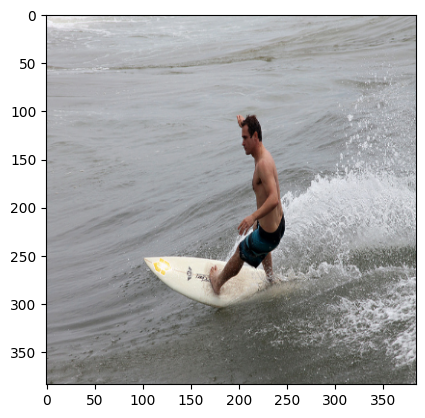

Sequence: tf.Tensor(
[   3    2   15   13   68    5  293    7    2  252 7999    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(75,), dtype=int32)
Caption: ['<start>', 'a', 'man', 'is', 'riding', 'the', 'wave', 'on', 'a', 'surfboard', '<end>']


In [33]:
def show_example(dataset, tokenizer):
    for (imgs, captions) in dataset.take(1):
        img = imgs[0]
        plt.imshow(imgs[0])
        plt.show()
        print('Sequence:', captions[0])
        print('Caption:', [tokenizer.index_word[i] for i in captions[0].numpy() if i != 0])
    return img
show_example(coco_train_dataset, uni_tokenizer);

In [34]:
coco_train_dataset.element_spec

(TensorSpec(shape=(12, 384, 384, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(12, 75), dtype=tf.int32, name=None))

In [88]:
(roast_train_dataset, roast_test_dataset, roast_val_dataset), roast_tokenizer = get_data(REDDIT_PATH, roast_annotation_file, is_roast=True,
                                                                     subset=None, batch_size=BATCH_SIZE,
                                                                           tokenizer=None)

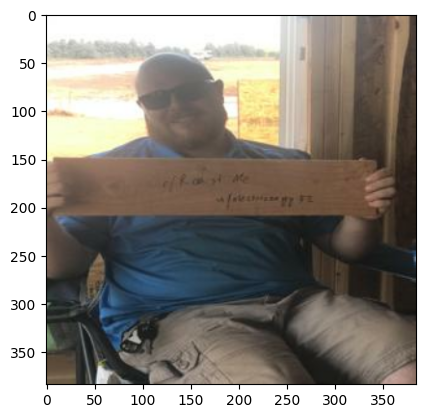

Sequence: tf.Tensor(
[   2    7   83   17 1209    9   45   10   76    1    1   30  982 7999
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(75,), dtype=int32)
Caption: ['<start>', 'your', 'head', 'is', 'shaped', 'like', 'one', 'of', 'those', '<unk>', '<unk>', 'from', 'walmart', '<end>']


In [89]:
show_example(roast_train_dataset, roast_tokenizer);

In [113]:
train_step_signature = [
    tf.TensorSpec(shape=(BATCH_SIZE, 384, 384, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(BATCH_SIZE, 75), dtype=tf.int32),
]

test_step_signature = [
    tf.TensorSpec(shape=(BATCH_SIZE, 384, 384, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(BATCH_SIZE, 75), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, target):
    tar_inp = target[:, :-1]
    tar_real = target[:, 1:]
    
    combined_mask, dec_padding_mask = create_masks(tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer((inp, tar_inp,
                                 True,
                                 None,
                                 combined_mask,
                                 dec_padding_mask))
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

@tf.function(input_signature=test_step_signature)
def test_step(inp, target):
    tar_inp = target[:, :-1]
    tar_real = target[:, 1:]
    
    combined_mask, dec_padding_mask = create_masks(tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer((inp, tar_inp,
                                    False,
                                    None,
                                    combined_mask,
                                    dec_padding_mask))
        loss = loss_function(tar_real, predictions)
    test_loss(loss)
    test_accuracy(accuracy_function(tar_real, predictions))

In [91]:
tf.config.list_physical_devices('GPU')

[]

In [114]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [154]:
def train_model(num_epochs, initial_epoch=0, initial_batch=0, print_freq=50):
    # First epoch
    train_epoch(initial_epoch, initial_batch, print_freq=print_freq)
    for epoch in range(initial_epoch+1, num_epochs):
        train_epoch(epoch, 0, print_freq=print_freq)
        
def train_epoch(current_epoch, initial_batch, print_freq=50):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    # inp -> image, tar -> caption
    for (batch, (inp, tar)) in tqdm(enumerate(roast_train_dataset.skip(initial_batch))):
        train_step(inp, tar)

        if batch % print_freq == 0:
              print(f'Epoch {current_epoch + 1} Batch {batch + initial_batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if (epoch + 1) % 3 == 0:
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {current_epoch+1} at {ckpt_save_path}')

            print(f'Epoch {current_epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
    
    # test step
    start = time.time()
    test_loss.reset_states()
    test_accuracy.reset_states()
    print(f'Time taken for 1 test epoch: {time.time() - start:.2f} secs\n')
    for (batch, (inp, tar)) in tqdm(enumerate(roast_test_dataset)):
        test_step(inp, tar)
        
        if batch % print_freq == 0:
            print(f'Test step: Epoch {epoch + 1} Batch {batch} Loss {test_loss.result():.4f} Accuracy {test_accuracy.result():.4f}')

In [163]:
train_model(num_epochs=9, initial_epoch=0, initial_batch=13110)

0it [00:00, ?it/s]

Epoch 1 Batch 1910 Loss 0.9429 Accuracy 0.9434
Epoch 1 Batch 1960 Loss 0.8854 Accuracy 0.9331
Epoch 1 Batch 2010 Loss 0.9021 Accuracy 0.9316
Epoch 1 Batch 2060 Loss 0.9136 Accuracy 0.9307
Epoch 1 Batch 2110 Loss 0.9025 Accuracy 0.9321
Epoch 1 Batch 2160 Loss 0.8921 Accuracy 0.9325
Epoch 1 Batch 2210 Loss 0.8878 Accuracy 0.9331
Epoch 1 Batch 2260 Loss 0.8864 Accuracy 0.9330
Epoch 1 Batch 2310 Loss 0.8762 Accuracy 0.9338
Epoch 1 Batch 2360 Loss 0.8691 Accuracy 0.9345
Epoch 1 Batch 2410 Loss 0.8618 Accuracy 0.9355
Epoch 1 Batch 2460 Loss 0.8525 Accuracy 0.9365
Epoch 1 Batch 2510 Loss 0.8473 Accuracy 0.9369
Epoch 1 Batch 2560 Loss 0.8395 Accuracy 0.9374
Epoch 1 Batch 2610 Loss 0.8291 Accuracy 0.9383
Epoch 1 Batch 2660 Loss 0.8206 Accuracy 0.9389
Epoch 1 Batch 2710 Loss 0.8141 Accuracy 0.9394
Epoch 1 Batch 2760 Loss 0.8055 Accuracy 0.9403
Epoch 1 Batch 2810 Loss 0.7979 Accuracy 0.9409
Epoch 1 Batch 2860 Loss 0.7903 Accuracy 0.9417
Epoch 1 Batch 2910 Loss 0.7824 Accuracy 0.9424
Epoch 1 Batch

Epoch 1 Batch 10660 Loss 0.2565 Accuracy 0.9842
Epoch 1 Batch 10710 Loss 0.2551 Accuracy 0.9843
Epoch 1 Batch 10760 Loss 0.2539 Accuracy 0.9844
Epoch 1 Batch 10810 Loss 0.2526 Accuracy 0.9844
Epoch 1 Batch 10860 Loss 0.2513 Accuracy 0.9845
Epoch 1 Batch 10910 Loss 0.2501 Accuracy 0.9846
Epoch 1 Batch 10960 Loss 0.2488 Accuracy 0.9847
Epoch 1 Batch 11010 Loss 0.2476 Accuracy 0.9848
Epoch 1 Batch 11060 Loss 0.2464 Accuracy 0.9848
Epoch 1 Batch 11110 Loss 0.2451 Accuracy 0.9849
Epoch 1 Batch 11160 Loss 0.2440 Accuracy 0.9850
Epoch 1 Batch 11210 Loss 0.2428 Accuracy 0.9850
Epoch 1 Batch 11260 Loss 0.2416 Accuracy 0.9851
Epoch 1 Batch 11310 Loss 0.2404 Accuracy 0.9852
Epoch 1 Batch 11360 Loss 0.2393 Accuracy 0.9853
Epoch 1 Batch 11410 Loss 0.2381 Accuracy 0.9853
Epoch 1 Batch 11460 Loss 0.2370 Accuracy 0.9854
Epoch 1 Batch 11510 Loss 0.2359 Accuracy 0.9855
Epoch 1 Batch 11560 Loss 0.2348 Accuracy 0.9855
Epoch 1 Batch 11610 Loss 0.2337 Accuracy 0.9856
Epoch 1 Batch 11660 Loss 0.2326 Accuracy

KeyboardInterrupt: 

In [164]:
transformer.summary()

Model: "transformer_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (12, 384, 384, 3)         0         
_________________________________________________________________
encoder_9 (Encoder)          multiple                  77858634  
_________________________________________________________________
decoder_9 (Decoder)          multiple                  59748354  
_________________________________________________________________
dense_72 (Dense)             multiple                  6152000   
Total params: 143,758,988
Trainable params: 143,758,988
Non-trainable params: 0
_________________________________________________________________


In [ ]:
transformer.save('savedmodels/transformer')

In [166]:
predict_transformer = Transformer(num_encoders=2, num_decoders=2, d_model=768, num_heads = 8, dff = 2048,
    input_size = 9*16*16*3, target_vocab_size = 8000, batch_size=1,
    img_input=10000, target=6000)
if os.path.exists('./checkpoints/transformer_base_model_2.index'):
    predict_transformer.load_weights('./checkpoints/transformer_base_model_2')

In [169]:
sample_input = tf.random.uniform((1,384,384,3), minval=0., maxval=1.)
sample_output = tf.random.uniform((1,74), minval=0, maxval=8000)
predictions, attention_weights = predict_transformer((sample_input,
                                                     sample_output,
                                                     False,
                                                     None,
                                                     None,
                                                     None))
predictions.shape

TensorShape([1, 74, 8000])

In [176]:
def generate_roast(image, tokenizer, max_length=75, temperature=1.):
    encoder_input = tf.expand_dims(image,0)
    start, end = tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
    output = tf.convert_to_tensor([start])
    output = tf.expand_dims(output, 0)
    #print(output)
    for i in range(max_length-1):
        lookahead_mask, dec_padding_mask = create_masks(output)
        # predictions.shape = (batch_size, seq_len, vocab_size)
        predictions, attention_weights = predict_transformer((encoder_input,
                                                    output,
                                                    False,
                                                    None,
                                                    lookahead_mask,
                                                    dec_padding_mask))
        predictions = predictions[:, -1:, :]
        #print('Predictions:', predictions)
        predicted_id = tf.random.categorical(predictions[0]/temperature, num_samples=1)[0]
        predicted_id = tf.expand_dims(tf.cast(predicted_id, output.dtype),0)
        #predicted_id = tf.cast(tf.argmax(predictions, axis=-1), output.dtype)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
        #print(output)
        if predicted_id == end:
            print('Found end')
            break
    print(output)
    text = tokenizer.sequences_to_texts(np.array(output))[0]
    return text, attention_weights

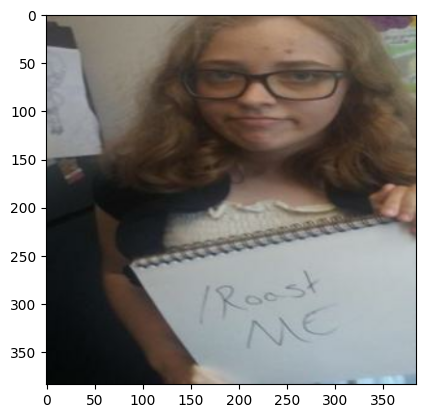

Sequence: tf.Tensor(
[   2  129   24   64 5206   18    7   35  151   16    5  984 7999    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(75,), dtype=int32)
Caption: ['<start>', 'there', 'are', 'more', 'spots', 'on', 'your', 'face', 'then', 'in', 'the', 'sun', '<end>']


In [194]:
img = show_example(roast_val_dataset, roast_tokenizer)

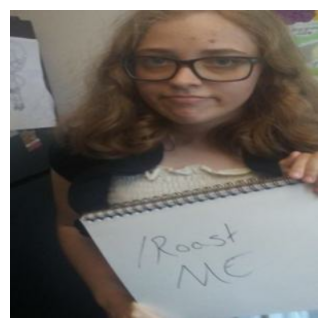

Image size: 384 X 384
Patch size: 16 X 16
Patches per image: 576
Elements per patch: 768


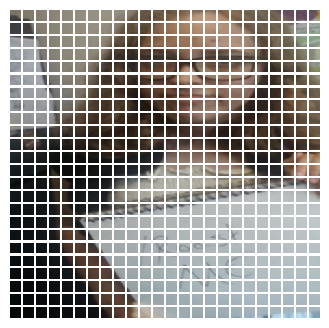

In [195]:
image_size = 384
patch_size = 16
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.show()

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(image_size, image_size)
)
patches = Patches(patch_size, 1)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")
plt.show()

In [179]:
text, attention_weights = generate_roast(img, roast_tokenizer, temperature=1.)
text

tf.Tensor(
[[   2  584  505  505 2657 2732 3062 2024 3137 2681  329 3114 1749 1284
  3811  914  505  505  505  505  146  585  505  505  505  505  505  505
   505  505  505  505  505  505  505  505  505  974  505  505  505  505
   505  505  584  505  505  505  505   95  505  505  505  505  505  505
   505  505  505  505  505  505  505  505  505  505  505  505  505  505
   505  505  505  505  505]], shape=(1, 75), dtype=int32)


'<start> finger count count bun iphone flight bank wave stripper great pole popular i’ll medicine tiny count count count count says bed count count count count count count count count count count count count count count count somebody count count count count count count finger count count count count people count count count count count count count count count count count count count count count count count count count count count count count count count'

In [165]:
transformer.save_weights('./checkpoints/transformer_base_model_2')